# ETF 历史溢价（折溢价率）查看器

- 数据来源：TuShare Pro `fund_adj`（字段 `discount_rate`），本工程落库到 SQLite 表 `adj_factor_etf`。
- 目标：绘制多个 ETF 的 `discount_rate`（折溢价率）历史变化曲线到一张图。

如本地数据库缺数据，先运行：`bash scripts/fetch_data.sh`（或 `python scripts/fetch_data.py`）。


In [1]:
# Bootstrap: make `src/` importable in notebooks
import _bootstrap

_bootstrap.add_src_to_sys_path()

import datetime as dt
import warnings

import pandas as pd

try:
    import matplotlib
    import matplotlib.pyplot as plt

    def _pick_cjk_font() -> str | None:
        """Pick a font that can render Chinese (avoid garbled text)."""
        try:
            from matplotlib import font_manager
        except Exception:
            return None

        available = {f.name for f in font_manager.fontManager.ttflist}
        preferred = [
            "Noto Sans CJK SC",
            "Noto Sans CJK",
            "Noto Sans SC",
            "Source Han Sans SC",
            "Microsoft YaHei",
            "SimHei",
            "SimSun",
            "PingFang SC",
            "WenQuanYi Zen Hei",
            "WenQuanYi Micro Hei",
            "Arial Unicode MS",
        ]
        for name in preferred:
            if name in available:
                return name

        # Last resort: download and register Noto CJK (cached under ~/.cache).
        try:
            from pathlib import Path
            import urllib.request
        except Exception:
            return None

        url = (
            "https://github.com/googlefonts/noto-cjk/raw/main/Sans/OTF/SimplifiedChinese/"
            "NotoSansCJKsc-Regular.otf"
        )
        font_path = Path.home() / ".cache" / "qs" / "fonts" / "NotoSansCJKsc-Regular.otf"
        if not font_path.exists():
            try:
                font_path.parent.mkdir(parents=True, exist_ok=True)
                urllib.request.urlretrieve(url, font_path)
            except Exception:
                return None

        try:
            font_manager.fontManager.addfont(str(font_path))
            return font_manager.FontProperties(fname=str(font_path)).get_name()
        except Exception:
            return None

    cjk = _pick_cjk_font()
    if cjk:
        matplotlib.rcParams["font.sans-serif"] = [cjk, *matplotlib.rcParams.get("font.sans-serif", [])]
        matplotlib.rcParams["axes.unicode_minus"] = False
    else:
        warnings.warn(
            "No CJK font found for matplotlib; Chinese may look garbled. "
            "Try installing a CJK font (Linux: apt-get fonts-noto-cjk; conda: conda-forge::fonts-noto-cjk), "
            "or re-run with network access to download NotoSansCJKsc-Regular.otf.",
            RuntimeWarning,
        )
except Exception as e:  # pragma: no cover
    raise RuntimeError(f"matplotlib is required for this notebook: {e!r}")

from qs.sqlite_utils import connect_sqlite, table_exists


In [2]:
# 参数
DB_PATH = _bootstrap.RAW_DB_PATH

# 以该 ETF 为 0 基准（支持输入 6 位代码或 ts_code）
BASELINE_CODE = "313100"

# 你关心的其他 ETF（支持输入 6 位代码或 ts_code）
ETF_CODES = ["159501", "513390", "159696", "513100"]

# 去重并保持顺序：基准 + 其他
INPUT_CODES = []
for c in [BASELINE_CODE, *ETF_CODES]:
    if c and c not in INPUT_CODES:
        INPUT_CODES.append(c)

# 日期范围（YYYYMMDD）
START_DATE = "20230101"
END_DATE = None  # e.g. "20251231"

if not DB_PATH.exists():
    raise FileNotFoundError(f"Missing DB: {DB_PATH} (run scripts/fetch_data.sh first)")

print("DB:", DB_PATH)


DB: /root/dev/quant_strategy_v2/data/data.sqlite


In [3]:
def _resolve_ts_code(con, code: str) -> tuple[str, str]:
    """Resolve user input to (ts_code, csname) via etf_basic."""
    c = str(code).strip()
    if "." in c:
        row = con.execute(
            "SELECT ts_code, csname FROM etf_basic WHERE ts_code=? LIMIT 1",
            [c],
        ).fetchone()
        if not row:
            raise ValueError(f"Unknown ETF ts_code={c!r} (not found in etf_basic)")
        return str(row[0]), str(row[1])

    rows = con.execute(
        "SELECT ts_code, csname FROM etf_basic WHERE ts_code LIKE ?",
        [f"{c}.%"],
    ).fetchall()
    if len(rows) == 1:
        return str(rows[0][0]), str(rows[0][1])
    if len(rows) == 0:
        raise ValueError(f"Unknown ETF code={c!r} (not found in etf_basic)")

    # etf_basic may contain both `xxxxxx.OF` and `xxxxxx.SZ/SH` rows.
    # For this notebook, prefer the ts_code that actually exists in adj_factor_etf.
    if table_exists(con, "adj_factor_etf"):
        hits: list[tuple[object, object]] = []
        for ts_code, csname in rows:
            hit = con.execute(
                "SELECT 1 FROM adj_factor_etf WHERE ts_code=? LIMIT 1",
                [ts_code],
            ).fetchone()
            if hit:
                hits.append((ts_code, csname))
        if len(hits) == 1:
            return str(hits[0][0]), str(hits[0][1])
        if len(hits) > 1:
            rows = hits

    preferred_suffixes = (".SZ", ".SH", ".BJ")
    preferred = [(t, n) for t, n in rows if str(t).endswith(preferred_suffixes)]
    if len(preferred) == 1:
        return str(preferred[0][0]), str(preferred[0][1])

    non_of = [(t, n) for t, n in rows if not str(t).endswith(".OF")]
    if len(non_of) == 1:
        return str(non_of[0][0]), str(non_of[0][1])

    raise ValueError(
        f"Ambiguous ETF code={c!r}: {[r[0] for r in rows]} (please use full ts_code like '159501.SZ')"
    )


def load_etf_discount_rate_history(
    con,
    *,
    ts_codes: list[str],
    start_date: str | None,
    end_date: str | None,
) -> pd.DataFrame:
    if not table_exists(con, "adj_factor_etf"):
        raise RuntimeError(
            "Missing table adj_factor_etf. Run scripts/fetch_data.sh (or data_fetcher sync) first."
        )

    if not ts_codes:
        raise ValueError("ts_codes is empty")

    placeholders = ",".join(["?"] * len(ts_codes))
    start = start_date
    if start is None or str(start).strip().lower() in {"auto", ""}:
        row = con.execute(
            f"SELECT MIN(trade_date) FROM adj_factor_etf WHERE ts_code IN ({placeholders}) AND discount_rate IS NOT NULL",
            ts_codes,
        ).fetchone()
        if not row or row[0] is None:
            raise RuntimeError("No data found in adj_factor_etf for selected ETFs")
        start = str(row[0])
    start = str(start)

    where = [f"ts_code IN ({placeholders})", "trade_date >= ?"]
    params: list[object] = [*ts_codes, start]
    if end_date:
        where.append("trade_date <= ?")
        params.append(end_date)

    sql = f"""
    SELECT ts_code,
           trade_date,
           discount_rate
    FROM adj_factor_etf
    WHERE {' AND '.join(where)}
    ORDER BY trade_date, ts_code
    """

    df = pd.read_sql_query(sql, con, params=params)
    if df.empty:
        return df
    df["trade_date"] = pd.to_datetime(df["trade_date"].astype(str))
    df["discount_rate"] = pd.to_numeric(df["discount_rate"], errors="coerce")
    return df


with connect_sqlite(DB_PATH, read_only=True) as con:
    try:
        baseline_ts_code, baseline_name = _resolve_ts_code(con, BASELINE_CODE)
    except ValueError as e:
        # Fallback: if user typed a non-existing 6-digit code, try searching codes with the same last 5 digits.
        # Example: '313100' might actually exist as '513100.SH' in etf_basic.
        c = str(BASELINE_CODE).strip()
        candidates: list[tuple[str, str]] = []
        if c.isdigit() and len(c) == 6:
            pattern = f"_{c[1:]}.%"
            rows = con.execute(
                "SELECT ts_code, csname FROM etf_basic WHERE ts_code LIKE ? LIMIT 20",
                [pattern],
            ).fetchall()

            # Only keep candidates that actually have discount_rate history.
            if table_exists(con, "adj_factor_etf"):
                hits: list[tuple[object, object]] = []
                for ts_code, csname in rows:
                    hit = con.execute(
                        "SELECT 1 FROM adj_factor_etf WHERE ts_code=? LIMIT 1",
                        [ts_code],
                    ).fetchone()
                    if hit:
                        hits.append((ts_code, csname))
                rows = hits

            candidates = [(str(t), str(n)) for t, n in rows]

        if len(candidates) == 1:
            baseline_ts_code, baseline_name = candidates[0]
            print(
                f"NOTE: BASELINE_CODE={BASELINE_CODE!r} not found; fallback baseline -> "
                f"{baseline_ts_code} {baseline_name}"
            )
        else:
            hint = f" Candidates with same last-5 digits: {candidates}" if candidates else ""
            raise ValueError(
                f"Baseline ETF code {BASELINE_CODE!r} not found/ambiguous in etf_basic." + hint + " "
                "Please update BASELINE_CODE to a valid 6-digit code or full ts_code like '313100.SZ'."
            ) from e

    RESOLVED: dict[str, tuple[str, str]] = {BASELINE_CODE: (baseline_ts_code, baseline_name)}
    for c in ETF_CODES:
        ts_code, name = _resolve_ts_code(con, c)
        RESOLVED[c] = (ts_code, name)

ts_codes = []
for ts_code, _name in RESOLVED.values():
    if ts_code not in ts_codes:
        ts_codes.append(ts_code)
labels = {t: f"{t.split('.')[0]} {name}" for _c, (t, name) in RESOLVED.items()}

BASELINE_TS_CODE = baseline_ts_code
BASELINE_LABEL = labels[BASELINE_TS_CODE]

with connect_sqlite(DB_PATH, read_only=True) as con:
    raw = load_etf_discount_rate_history(
        con,
        ts_codes=ts_codes,
        start_date=START_DATE,
        end_date=END_DATE,
    )

raw.head()


NOTE: BASELINE_CODE='313100' not found; fallback baseline -> 513100.SH 国泰纳斯达克100(QDII-ETF)


,ts_code,trade_date,discount_rate
0,513100.SH,2023-01-03,3.2010
1,513100.SH,2023-01-04,3.3419
2,513100.SH,2023-01-05,4.4099
3,513100.SH,2023-01-06,3.3635
4,513100.SH,2023-01-09,6.5876


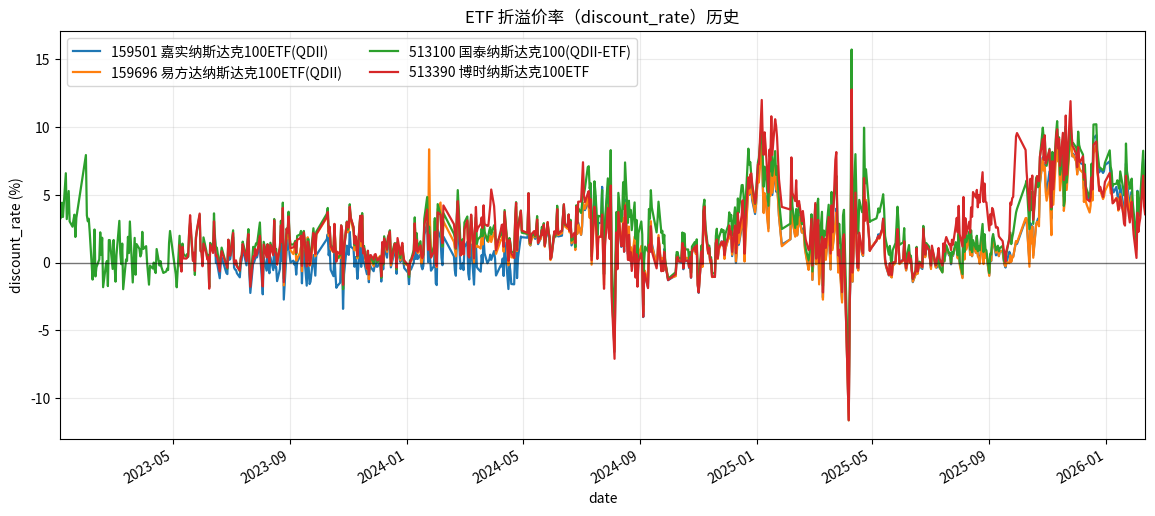

In [4]:
if raw.empty:
    raise RuntimeError(
        "Query returned no rows. Check START_DATE/END_DATE and whether adj_factor_etf has data for these ETFs."
    )

plot_df = raw.copy()
plot_df["label"] = plot_df["ts_code"].map(labels)

# 把时间窗口拉到“历史最长”的那只 ETF；其他 ETF 若初期缺数据则不画（从各自首个有效值开始）
first_dates = (
    plot_df.dropna(subset=["discount_rate"]).groupby("ts_code")["trade_date"].min().to_dict()
)

# index=日期, columns=ETF, values=折溢价率
pivot = (
    plot_df.pivot(index="trade_date", columns="label", values="discount_rate")
    .sort_index()
)

for ts_code, first_dt in first_dates.items():
    col = labels.get(ts_code)
    if col in pivot.columns:
        pivot.loc[pivot.index < first_dt, col] = float("nan")

fig, ax = plt.subplots(figsize=(14, 6))
pivot.plot(ax=ax, linewidth=1.6)
ax.axhline(0, color="black", linewidth=1, alpha=0.5)
ax.set_title("ETF 折溢价率（discount_rate）历史")
ax.set_ylabel("discount_rate (%)")
ax.set_xlabel("date")
ax.set_xlim(pivot.index.min(), pivot.index.max())
ax.grid(True, alpha=0.25)
ax.legend(loc="upper left", ncols=2)
plt.show()


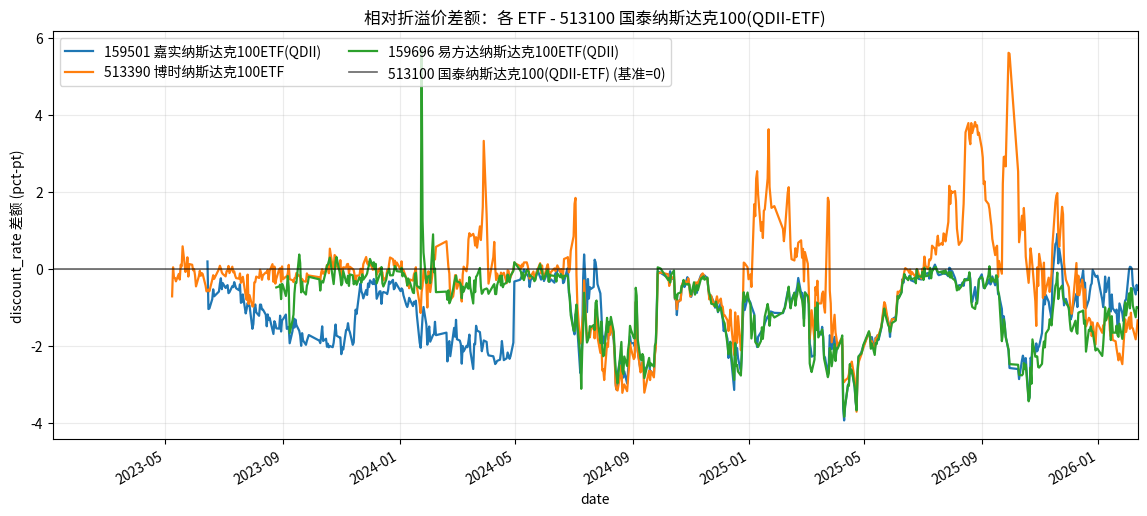

In [5]:
# 相对折溢价差额曲线（以 BASELINE_CODE 为 0 基准）：差额 = 当前 ETF - 基准 ETF
baseline_col = BASELINE_LABEL
if baseline_col not in pivot.columns:
    raise RuntimeError(
        f"Baseline column {baseline_col!r} not found in pivot. "
        f"Available columns={list(pivot.columns)}"
    )

relative = pivot.sub(pivot[baseline_col], axis=0)

# 按输入顺序（基准在前）决定绘图顺序；基准本身用 0 线表示
ordered_labels = []
for input_code in INPUT_CODES:
    if input_code == BASELINE_CODE:
        continue
    ts_code, _name = RESOLVED[input_code]
    col = labels.get(ts_code)
    if col == baseline_col:
        continue
    if col and col in relative.columns and col not in ordered_labels:
        ordered_labels.append(col)

fig, ax = plt.subplots(figsize=(14, 6))
if ordered_labels:
    relative[ordered_labels].plot(ax=ax, linewidth=1.6)
ax.axhline(0, color="black", linewidth=1.2, alpha=0.6, label=f"{baseline_col} (基准=0)")
ax.set_title(f"相对折溢价差额：各 ETF - {baseline_col}")
ax.set_ylabel("discount_rate 差额 (pct-pt)")
ax.set_xlabel("date")
ax.set_xlim(relative.index.min(), relative.index.max())
ax.grid(True, alpha=0.25)
ax.legend(loc="upper left", ncols=2)
plt.show()


In [6]:
# 打印本图包含的 ETF（输入代码 -> ts_code 名称 + 本地数据范围）
print("ETF 列表（本次绘图使用的本地数据范围）：")

stats = raw.groupby("ts_code")["trade_date"].agg(["min", "max", "count"])
with connect_sqlite(DB_PATH, read_only=True) as con:
    placeholders = ",".join(["?"] * len(ts_codes))
    list_dates = dict(
        con.execute(
            f"SELECT ts_code, list_date FROM etf_basic WHERE ts_code IN ({placeholders})",
            ts_codes,
        ).fetchall()
    )

for input_code in INPUT_CODES:
    ts_code, name = RESOLVED[input_code]
    if ts_code not in stats.index:
        print(f"- {input_code} -> {ts_code} {name} (no rows)")
        continue
    s = stats.loc[ts_code]
    start = s["min"].strftime("%Y-%m-%d")
    end = s["max"].strftime("%Y-%m-%d")
    cnt = int(s["count"])
    listed = list_dates.get(ts_code)
    listed_str = f"list_date={listed}" if listed else "list_date=?"
    print(f"- {input_code} -> {ts_code} {name} ({listed_str}, rows={cnt}, range={start}~{end})")

latest_starts_late = []
for ts_code in ts_codes:
    listed = list_dates.get(ts_code)
    if not listed or ts_code not in stats.index:
        continue
    if stats.loc[ts_code, "min"].strftime("%Y%m%d") > str(listed):
        latest_starts_late.append(ts_code)
if latest_starts_late:
    print(
        "\n提示：部分 ETF 的本地数据起点晚于 list_date，说明 SQLite 里还没补齐历史数据。"
    )


ETF 列表（本次绘图使用的本地数据范围）：
- 313100 -> 513100.SH 国泰纳斯达克100(QDII-ETF) (list_date=20130515, rows=755, range=2023-01-03~2026-02-11)
- 159501 -> 159501.SZ 嘉实纳斯达克100ETF(QDII) (list_date=20230614, rows=648, range=2023-06-14~2026-02-11)
- 513390 -> 513390.SH 博时纳斯达克100ETF (list_date=20230508, rows=675, range=2023-05-08~2026-02-11)
- 159696 -> 159696.SZ 易方达纳斯达克100ETF(QDII) (list_date=20230825, rows=598, range=2023-08-25~2026-02-11)
- 513100 -> 513100.SH 国泰纳斯达克100(QDII-ETF) (list_date=20130515, rows=755, range=2023-01-03~2026-02-11)

提示：部分 ETF 的本地数据起点晚于 list_date，说明 SQLite 里还没补齐历史数据。
